In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
from PIL import Image
import rasterio
import time
from graph_tool.all import *

/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [249]:
from power_planner.utils import angle, plot_path, shift_surface

## Test graph operations

In [587]:
g_test = Graph()
g_test.add_vertex(20)
weight = g_test.new_edge_property("float")
edges = []
for i in range(3,16):
    edges.append([i,i+1, i])
g_test.add_edge_list(edges, eprops=[weight])

In [590]:
edges = [[2,3,1], [16, 17,1]]
g_test.add_edge_list(edges)

In [591]:
v_path, e_path = shortest_path(g_test, g_test.vertex(2), g_test.vertex(17), weights=weight)

In [593]:
for e in e_path:
    print(weight[e])

0.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
0.0


### Load everything

In [3]:
base_path = "/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/outputs/"
graph_name = "path_01128"

In [5]:
g = load_graph(base_path+graph_name+"_graph.xml.gz")

In [6]:
w = g.ep.weight

In [7]:
costs = np.load(base_path+"cost_rest.npy")

In [9]:
pos2node = np.load(base_path+graph_name+"_pos2node.npy")

In [53]:
node_pos = []
for i in range(n_vertices):
    pos_x, pos_y = np.where(pos2node==i)
    node_pos.append((pos_x[0], pos_y[0]))

In [56]:
n_vertices = len(list(g.vertices()))
n_edges = len(list(g.edges()))
print("size of graph:", n_vertices, n_edges)

size of graph: 1049 3757


### Tests for correctness

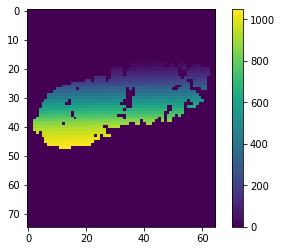

In [43]:
plt.imshow(pos2node)
plt.colorbar()
plt.show()

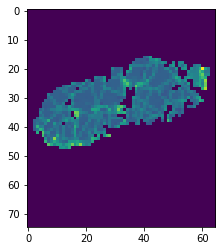

In [12]:
plt.imshow(costs)
plt.show()

In [14]:
v1 = g.vertex(pos2node[40,20])

In [26]:
for n in v1.out_neighbors():
    v_ind = g.vertex_index[n]
    pos_x, pos_y = np.where(pos2node==v_ind)
    print(pos_x[0], pos_y[0])
    print(w[g.edge(v1, v_ind)])

39 20
0.2832258064516129
39 21
0.2506653225806451
40 21
0.2507056451612903
41 21
0.266875


### Define line graph and helper arrays

In [171]:
g_line = Graph()

In [172]:
_ = g_line.add_vertex(n_edges)

In [173]:
# not necessary!
edge_mapping = []
for e in g.edges():
    edge_mapping.append(tuple(e))

In [174]:
max_shape = (int(np.max(pos2node))+1, int(np.max(pos2node))+1)

In [175]:
edge_to_node = np.ones(max_shape)
edge_to_node *= -1
for k, (i,j) in enumerate(edge_mapping):
    edge_to_node[int(i),int(j)] = k

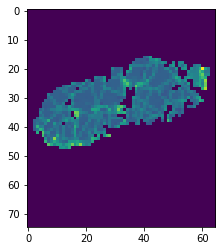

In [92]:
# plt.figure(figsize=(20,10))
plt.imshow(costs)
plt.show()

### Fill line graph with edges

In [127]:
len(edges)

11960

In [170]:
counter = 10
edges = []
for i, v in enumerate(g.vertices()):
    for in_nb in v.in_neighbours():
        for out_nb in v.out_neighbours():
            in_nb_ind = node_pos[int(in_nb)]
            out_nb_ind = node_pos[int(out_nb)]
            pos = node_pos[i]
            # vector between: subtract two pos tuples
            vec1 = np.subtract(in_nb_ind, pos)
            vec2 = np.subtract(pos, out_nb_pos)
            angle_cost = angle(vec1, vec2)/(0.5*np.pi)
            # print(node_pos[int(in_nb)], node_pos[g.vertex_index[v]], node_pos[int(out_nb)])
            # print(angle(vec1, vec2))
            if angle_cost <= 1:
                v1_line = edge_to_node[int(in_nb), i]
                v2_line = edge_to_node[i, int(out_nb)]
                # w[g.edge(v1, v_ind)]
                cost_before = costs[pos[0], pos[1]]
                # print(cost_before, angle_cost)
                edges.append([v1_line, v2_line, 0.5 * angle_cost + cost_before])
    #if i>counter:
     #   break

In [176]:
w_line = g_line.new_edge_property("float")
g_line.add_edge_list(edges,  eprops=[w_line])

In [130]:
len(list(g_line.edges()))

11960

## Shortest path old

In [121]:
source = pos2node[40,6]
dest = pos2node[23,60]

In [131]:
vertices_path, _ = shortest_path(
                g,
                g.vertex(source),
                g.vertex(dest),
                weights=w,
                negative_weights=True
            )
path = [node_pos[g.vertex_index[v]] for v in vertices_path]

In [123]:
list(g.vertex(0).out_edges())

[<Edge object with source '0' and target '1' at 0x145b73eb0>,
 <Edge object with source '0' and target '7' at 0x145b73cb0>]

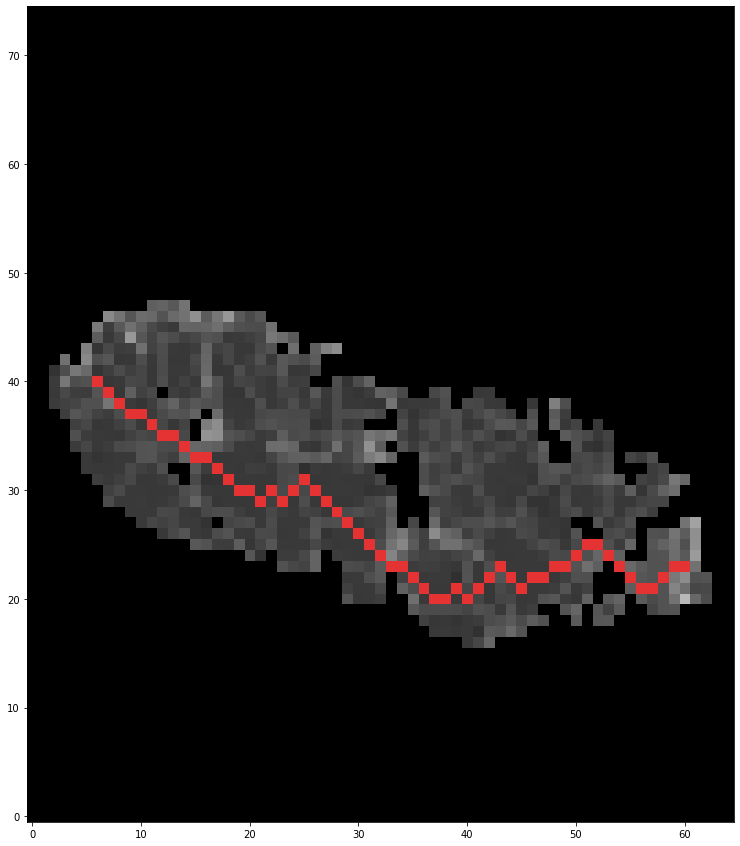

In [132]:
plot_path(costs, path, buffer=0)

## Shortest path new

In [177]:
source_line = g_line.add_vertex()
dest_line = g_line.add_vertex()

In [178]:
source_dest_edges = []
for e_out in g.vertex(source).out_edges():
    e_out = tuple(e_out)
    node_line = edge_to_node[int(e_out[0]), int(e_out[1])]
    print(node_line)
    source_dest_edges.append([g_line.vertex_index[source_line], node_line, 0])
    
for e_out in g.vertex(dest).in_edges():
    e_out = tuple(e_out)
    node_line = edge_to_node[int(e_out[0]), int(e_out[1])]
    print(node_line)
    source_dest_edges.append([node_line, g_line.vertex_index[dest_line], 0])

3220.0
3221.0
3222.0
3223.0
434.0
558.0
696.0
699.0


In [179]:
g_line.add_edge_list(source_dest_edges,  eprops=[w_line])

In [180]:
vertices_path, _ = shortest_path(
                g_line,
                source_line,
                dest_line,
                weights=w_line,
                negative_weights=True
            )
# path = [node_pos[g.vertex_index[v]] for v in vertices_path]

In [192]:
path_line = []
for i, v in enumerate(vertices_path[1:-1]):
    v_ind_line = g_line.vertex_index[v]
    edge_actual = tuple(list(g.edges())[v_ind_line])
    if i==0:
        path_line.append(node_pos[g.vertex_index[edge_actual[0]]])
    path_line.append(node_pos[g.vertex_index[edge_actual[1]]])

In [191]:
list(g.edges())[0]

<Edge object with source '0' and target '1' at 0x14b706d30>

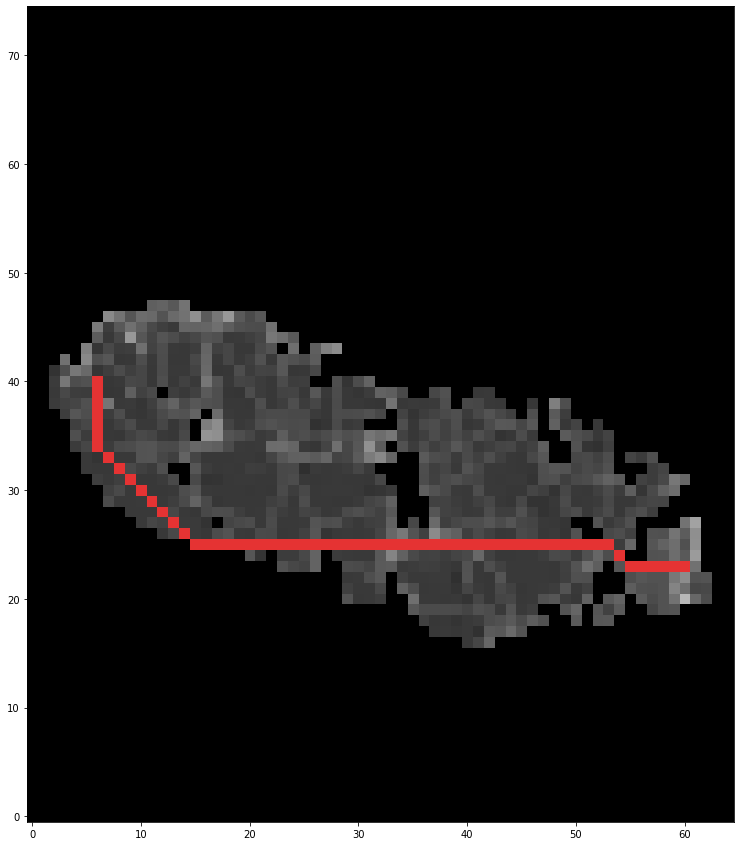

In [164]:
plot_path(costs, path_line, buffer=0)

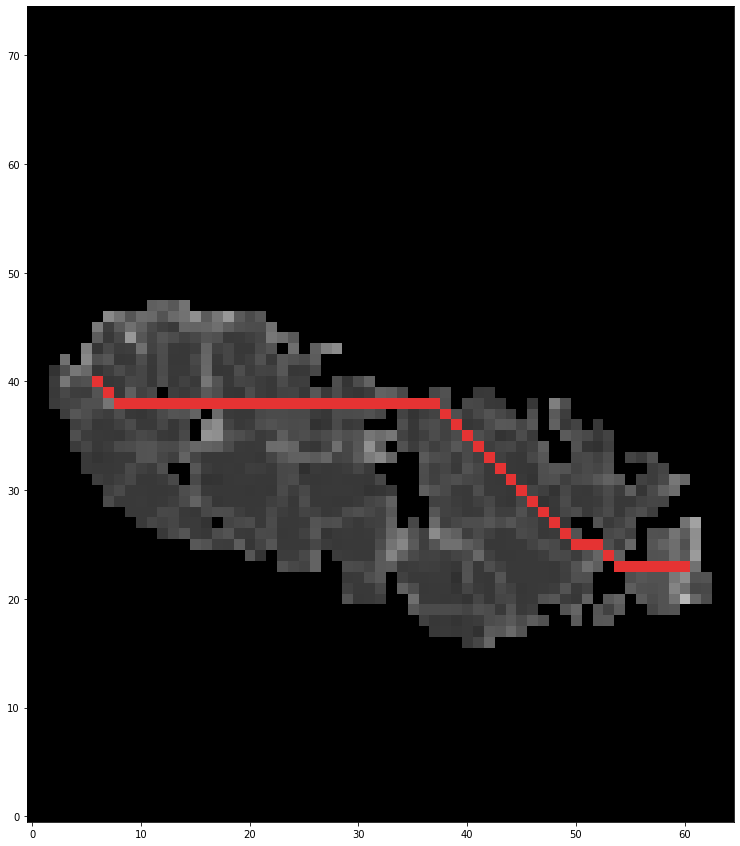

In [193]:
plot_path(costs, path_line, buffer=0)

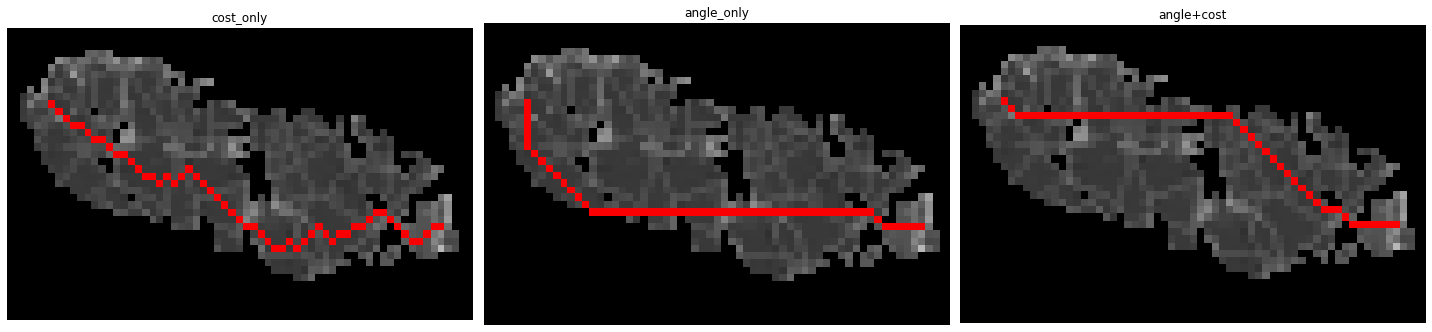

In [187]:
p = "/Users/ninawiedemann/Desktop/"
plt.figure(figsize=(20,10))
for i, f in enumerate(["cost_only", "angle_only", "angle+cost"]):
    img = plt.imread(p+f+".png")
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f)
plt.tight_layout()
plt.savefig("path_comparison.png")
plt.show()

## New donut tuples

In [194]:
def get_donut(radius_low, radius_high):
    """
    Compute all indices of points in donut around (0,0)
    :param radius_low: minimum radius
    :param radius_high: maximum radius
    :returns: tuples of indices of points with radius between radius_low 
    and radius_high around (0, 0)
    """
    img_size = int(radius_high + 10)
    # xx and yy are 200x200 tables containing the x and y coordinates as values
    # mgrid is a mesh creation helper
    xx, yy = np.mgrid[-img_size:img_size, -img_size:img_size]
    # circle equation
    circle = (xx)**2 + (yy)**2
    # donuts contains 1's and 0's organized in a donut shape
    # you apply 2 thresholds on circle to define the shape
    donut = np.logical_and(
        circle <= (radius_high**2), circle >= (radius_low**2)
    )
    pos_x, pos_y = np.where(donut > 0)
    return pos_x - img_size, pos_y - img_size

def get_half_donut(radius_low, radius_high, vec, angle_max=0.5 * np.pi):
    """
    Returns only the points with x >= 0 of the donut points (see above)
    :param radius_low: minimum radius
    :param radius_high: maximum radius
    :returns: tuples of indices of points with radius between radius_low 
    and radius_high around (0, 0)
    """
    pos_x, pos_y = get_donut(radius_low, radius_high)
    new_tuples = []
    shift_vals = []
    for i, j in zip(pos_x, pos_y):
        # if i > 0 or i == 0 and j > 0:
        # if i * vec[0] + j * vec[1] >= 0:
        ang = angle([i, j], vec)
        if ang <= angle_max:
            new_tuples.append((i, j))
            shift_vals.append(ang + 0.1)
    return new_tuples, shift_vals

In [195]:
donut = get_donut(2.5, 5)

In [227]:
vec = [1,1]
tuple_zip = list(zip(donut[0], donut[1]))
min_angle = 3*np.pi/4

In [552]:
def get_lg_donut(radius_low, radius_high, vec, min_angle= 3*np.pi/4):
    donut = get_donut(radius_low, radius_high)
    tuple_zip = list(zip(donut[0], donut[1]))
    linegraph_tuples = []
    for (i,j) in tuple_zip:
        # if in incoming half
        if i*vec[0] + j* vec[1] <= 0:
            for (k,l) in tuple_zip:
                ang = angle([k,l], [i,j])
                # min angle and general outgoing edges half
                if ang >= min_angle and k*vec[0] + l* vec[1] >= 0:
                    print(ang)
                    linegraph_tuples.append([[i,j], [k,l], round(1-(ang/np.pi),2)])
    return linegraph_tuples

In [550]:
lg_tuples = get_lg_donut(0.75,1.5, [1,1])

2.356194490192345
2.356194490192345
3.1415926325163688
2.356194490192345
3.141592653589793
2.356194490192345
3.1415926325163688
2.356194490192345
2.356194490192345
3.141592653589793
2.356194490192345
3.1415926325163688
2.356194490192345


In [551]:
lg_tuples

[[[-1, -1], [0, 1], 0.25],
 [[-1, -1], [1, 0], 0.25],
 [[-1, -1], [1, 1], 0.0],
 [[-1, 0], [1, -1], 0.25],
 [[-1, 0], [1, 0], 0.0],
 [[-1, 0], [1, 1], 0.25],
 [[-1, 1], [1, -1], 0.0],
 [[-1, 1], [1, 0], 0.25],
 [[0, -1], [-1, 1], 0.25],
 [[0, -1], [0, 1], 0.0],
 [[0, -1], [1, 1], 0.25],
 [[1, -1], [-1, 1], 0.0],
 [[1, -1], [0, 1], 0.25]]

In [289]:
example = lg_tuples[4]

In [242]:
example

[[-5, 0], [3, -1], 2.819842099193151]

In [247]:
np.where(np.roll(costs, example[1], axis=(0,1)))

(array([19, 19, 19, ..., 50, 50, 50]), array([39, 40, 41, ..., 11, 12, 13]))

In [248]:
np.where(costs)

(array([16, 16, 16, ..., 47, 47, 47]), array([40, 41, 42, ..., 12, 13, 14]))

### Shift in both directions

In [327]:
example_test = [[-1,-1],[1,1], 2]
costs_test = np.zeros((3,3))
costs_test[1,1]=1
costs_test[2,2]=1
costs_test[0,0]=1

In [331]:
in_edges = shift_surface(costs_test, np.asarray(example_test[0])*(-1))
out_edges = shift_surface(costs_test, np.asarray(example_test[1]))
possible_in_edges = np.where(costs_test * in_edges)
possible_out_edges = np.where(costs_test * out_edges)
print(possible_in_edges, possible_in_edges)
in_edge_2 = np.swapaxes(np.vstack(possible_in_edges), 1,0)
in_edge_1 = in_edge_2 + np.array(example_test[0])
node_to_edge = np.concatenate([np.expand_dims(in_edge_1, 1), np.expand_dims(in_edge_2, 1)], axis=1)

(array([1, 2]), array([1, 2]))


In [287]:
costs_bin = costs_test>0
out = valid_edges(costs_bin, example)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out) #out_node.astype(int)+costs_bin.astype(int))
plt.show()

In [254]:
np.where(in_node)

(array([11, 11, 11, ..., 42, 42, 42]), array([40, 41, 42, ..., 12, 13, 14]))

### Add nodes and edges

In [291]:
mask = costs>0

### First attempt

In [346]:
# for shift in shift tuples:
shift = example
in_edges = shift_surface(mask, np.asarray(shift[0])*(-1))
possible_in_edges = np.where(mask * in_edges)
in_edge_2 = np.swapaxes(np.vstack(possible_in_edges), 1,0)
in_edge_1 = in_edge_2 + np.array(shift[0])
in_edge = np.concatenate([np.expand_dims(in_edge_1, 1), np.expand_dims(in_edge_2, 1)], axis=1)

out_edges = shift_surface(mask, np.asarray(shift[1])*(-1))
possible_out_edges = np.where(mask * out_edges)
out_edge_2 = np.swapaxes(np.vstack(possible_out_edges), 1,0)
out_edge_1 = out_edge_2 + np.array(shift[1])
out_edge = np.concatenate([np.expand_dims(out_edge_1, 1), np.expand_dims(out_edge_2, 1)], axis=1)

### Working version: with edge mapping dictionary

In [512]:
shifts, _ = get_half_donut(0.75, 1.5, [-17, 54])

In [513]:
# Build edge dictionary
edge_array = []
for i in range(len(shifts)):
    out_edges = shift_surface(mask, np.asarray(shifts[i])*(-1))
    possible_out_edges = np.where(mask * out_edges)
    out_edge_2 = np.swapaxes(np.vstack(possible_out_edges), 1,0)
    out_edge_1 = out_edge_2 + np.array(shifts[i])
    out_edge = np.concatenate([np.expand_dims(out_edge_2, 1), np.expand_dims(out_edge_1, 1)], axis=1)
    edge_array.append(out_edge)
    
edge_lists_concat = np.concatenate(edge_array, axis=0)
edge_dict = {}
edge_dict = {(tuple(edge_lists_concat[i, 0]), tuple(edge_lists_concat[i,1])):i for i in range(len(edge_lists_concat))}

In [370]:
def valid_edges(mask, shift):
    in_node = shift_surface(mask, np.asarray(shift[0])*(-1))
    out_node = shift_surface(mask, np.asarray(shift[1])*(-1))
    stacked = np.asarray([mask, in_node, out_node])
    return np.all(stacked, axis =0)

In [553]:
lg_tuples = get_lg_donut(0.75, 1.5, [-17, 54]) # different before!

2.356194490192345
3.1415926325163688
2.356194490192345
3.141592653589793
2.356194490192345
2.356194490192345
3.1415926325163688
2.356194490192345
3.141592653589793
2.356194490192345


In [554]:
graph = Graph()
_ = graph.add_vertex(len(edge_lists_concat))
weight = graph.new_edge_property("float")

In [555]:
# for every angle in the new angle tuples
for shift in lg_tuples:
    print(shift[2])
    all_angles = valid_edges(mask,shift)
    node_inds = np.swapaxes(np.vstack(np.where(all_angles)), 1,0)
    node_cost = costs[all_angles]
    in_node = node_inds + shift[0]
    out_node = node_inds + shift[1]
    edges_lg = []
    for i in range(len(node_inds)):
        e1 = edge_dict[(tuple(in_node[i]), tuple(node_inds[i]))]
        e2 = edge_dict[(tuple(node_inds[i]), tuple(out_node[i]))]
        edges_lg.append([e1, e2, shift[2]]) # node_cost[i]])
    graph.add_edge_list(edges_lg, eprops=[weight])

0.25
0.0
0.25
0.0
0.25
0.25
0.0
0.25
0.0
0.25


In [538]:
lg_tuples

[[[-1, -1], [0, 1], 2.356194490192345],
 [[-1, -1], [1, 1], 3.1415926325163688],
 [[0, -1], [-1, 1], 2.356194490192345],
 [[0, -1], [0, 1], 3.141592653589793],
 [[0, -1], [1, 1], 2.356194490192345],
 [[1, -1], [-1, 0], 2.356194490192345],
 [[1, -1], [-1, 1], 3.1415926325163688],
 [[1, -1], [0, 1], 2.356194490192345],
 [[1, 0], [-1, 0], 3.141592653589793],
 [[1, 0], [-1, 1], 2.356194490192345]]

### Test 

In [524]:
edges_lg[20]

[34, 972, 1.2268145161290323]

In [525]:
edge_lists_concat[34]

array([[20, 43],
       [19, 43]])

In [526]:
edge_lists_concat[972]

array([[19, 43],
       [18, 44]])

In [527]:
len(edges_lg)*len(lg_tuples)

8550

### Add start and end

In [556]:
source = [40, 6]
dest = [23, 60]


possible_start_edges = []
for shift in shifts:
    neighbor = np.asarray(source) + np.asarray(shift)
    node_val = edge_dict.get(
        (tuple(source), tuple(neighbor)), -1
    )
    if node_val > 0:
        possible_start_edges.append(node_val)

possible_dest_edges = []
for shift in shifts:
    neighbor = np.asarray(dest) - np.asarray(shift)
    node_val = edge_dict.get(
        (tuple(neighbor), tuple(dest)), -1
    )
    if node_val > 0:
        possible_dest_edges.append(node_val)

start_v = graph.add_vertex()
dest_v = graph.add_vertex()
start_ind = graph.vertex_index[start_v]
dest_ind = graph.vertex_index[dest_v]

start_edges = [[start_ind, u, 1] for u in possible_start_edges]
dest_edges = [[u, dest_ind, 1] for u in possible_dest_edges]
graph.add_edge_list(start_edges)
graph.add_edge_list(dest_edges)

print([start_v, dest_v])


[<Vertex object with index '3757' at 0x14683ed50>, <Vertex object with index '3758' at 0x145544450>]


In [557]:
vertices_path, _ = shortest_path(
                graph,
                start_v,
                dest_v,
                weights=weight,
                negative_weights=True
            )
# path = [node_pos[g.vertex_index[v]] for v in vertices_path]

In [558]:
edge_mapping = [k for k, _ in sorted(edge_dict.items(), key=lambda item: item[1])]

In [559]:
out_path = [edge_mapping[graph.vertex_index[v]][0] for v in vertices_path[1:-1]]
out_path.append(edge_mapping[graph.vertex_index[vertices_path[-2]]][1])

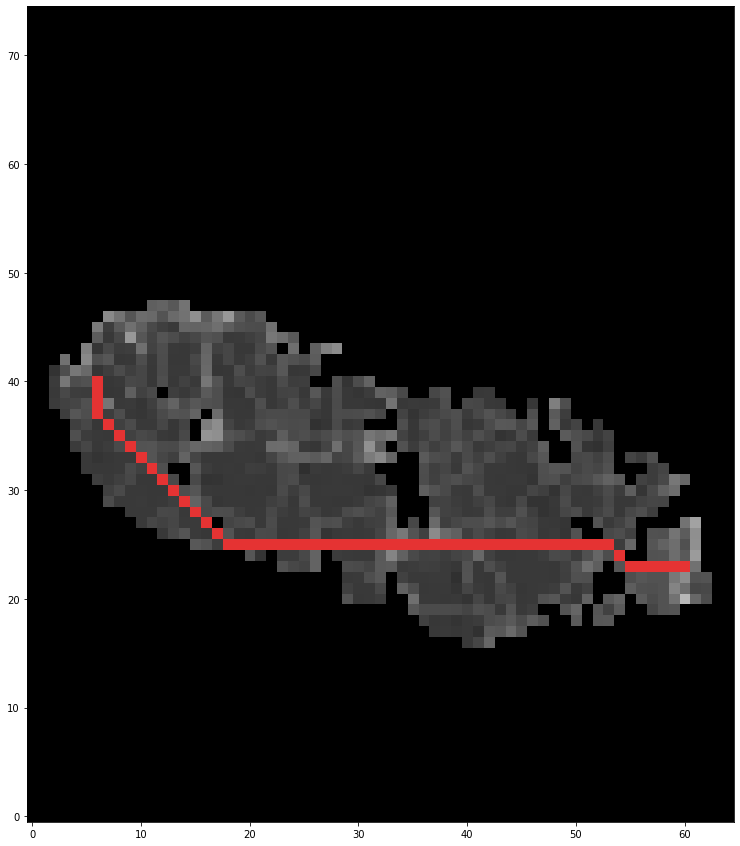

In [560]:
plot_path(costs, out_path, buffer=0)

## Compute sizes

len(edges_lg)

In [476]:
len(lg_tuples)

445

In [485]:
nodes_orig = len(list(g.vertices()))
edges_orig = len(list(g.edges()))
donuts = get_half_donut(0.75, 1.5, [1,1])

print("nodes", nodes_orig, "neighrbors", len(donuts[0]), "edges", edges_orig)

nodes 1049 neighrbors 5 edges 3757


In [486]:
nodes_lg = len(list(graph.vertices()))
edges_lg = len(list(graph.edges()))
# donuts = get_half_donut(0.75, 1.5, [1,1])
print("nodes lg", nodes_lg, "edges lg", edges_lg)


nodes lg 25992 edges lg 542531


In [488]:
print(len(start_edges), len(dest_edges))

26 23


In [504]:
lg_donut_new = get_lg_donut(0.75, 1.5, [1,1]) # different before!

In [505]:
first = np.asarray([l[0] for l in lg_donut_new])
second = np.asarray([l[1] for l in lg_donut_new])

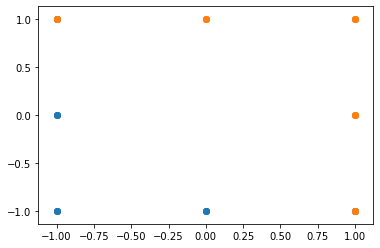

In [506]:
plt.scatter(first[:,0], first[:,1])
plt.scatter(second[:,0], second[:,1])

--> only so much bigger in notebook because more lg tuples taken into account